In [77]:
%matplotlib inline
from datetime import datetime
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import pytz
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib

In [78]:
matplotlib.style.use('bmh')
import warnings
warnings.filterwarnings('ignore')

In [79]:
data = pd.read_csv("historical.csv", parse_dates=['Date'], index_col=['Date'],dayfirst=True)
d_max = data.max()
d_min = data.min()
print d_max-d_min
data.describe()

Open         1.591260e+03
High         1.582260e+03
Low          1.599360e+03
Close        1.595190e+03
Adj Close    1.595190e+03
Volume       1.110016e+10
dtype: float64


,Open,High,Low,Close,Adj Close,Volume
count,4025.000000,4025.000000,4025.000000,4025.000000,4025.000000,4.025000e+03
mean,1372.709349,1380.982987,1363.801700,1372.926283,1372.926283,3.139891e+09
std,372.095835,372.038163,372.151102,372.250755,372.250755,1.531072e+09
min,679.280029,695.270020,666.789978,676.530029,676.530029,3.560700e+08
25%,1119.359985,1125.500000,1112.670044,1118.859985,1118.859985,1.674500e+09
50%,1275.650024,1282.739990,1266.739990,1275.530029,1275.530029,3.177710e+09
75%,1525.750000,1532.459961,1519.750000,1525.750000,1525.750000,4.051570e+09
max,2270.540039,2277.530029,2266.149902,2271.719971,2271.719971,1.145623e+10


In [80]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000
2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000
2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000
2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000
2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000


#### The following section corresponds to the exploratory visualization section in the report
As an overview, there is an individual price point graphs, followed by a cumulative graph with all the price points. There is one graph that is related to the volume tracked by the index that day

In [81]:
volume_data = data[['Volume']]
cumulative_price_points = data[['Open', 'High', 'Low', 'Close', 'Adj Close']]
individual_price_points = data[['Open']], data[['High']], data[['Low']], data[['Close']], data[['Adj Close']]

colors = ["red","blue","green", "yellow", "brown"]
idx = 0

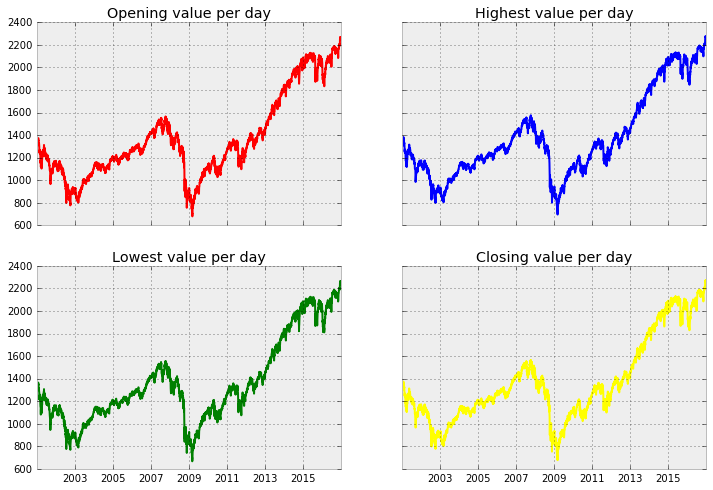

In [82]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(12,8))
ax1.plot(data[['Open']], color='red')
ax1.set_title('Opening value per day')
ax2.plot(data[['High']], color='blue')
ax2.set_title('Highest value per day')
ax3.plot(data[['Low']], color='green')
ax3.set_title('Lowest value per day')
ax4.plot(data[['Close']], color= 'yellow')
ax4.set_title('Closing value per day')
plt.savefig('')

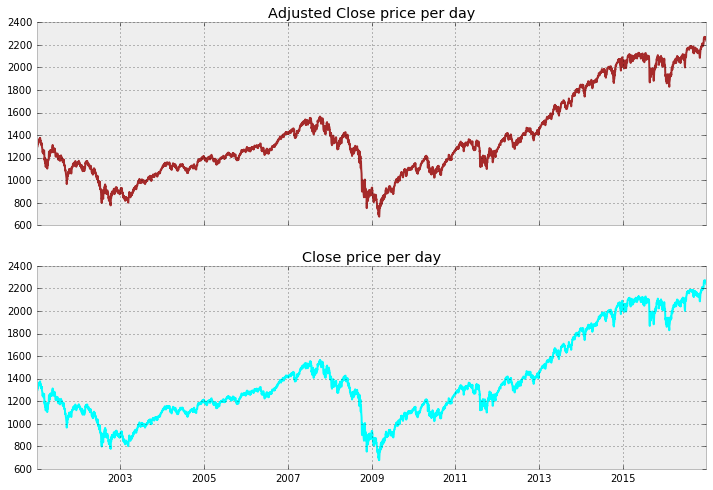

In [83]:
f, ((ax1, ax2)) = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(12,8))
ax1.plot(data[['Adj Close']], color='brown')
ax1.set_title('Adjusted Close price per day')
ax2.plot(data[['Close']], color='aqua')
ax2.set_title('Close price per day')
plt.savefig('')

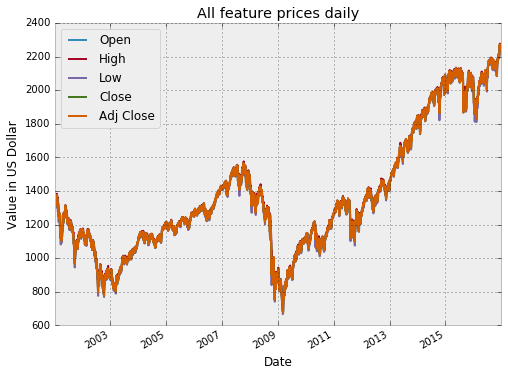

In [84]:
## cumulative graph
pp = cumulative_price_points.plot(figsize=(8,6))
pp.set_ylabel("Value in US Dollar")
pp.set_title("All feature prices daily")

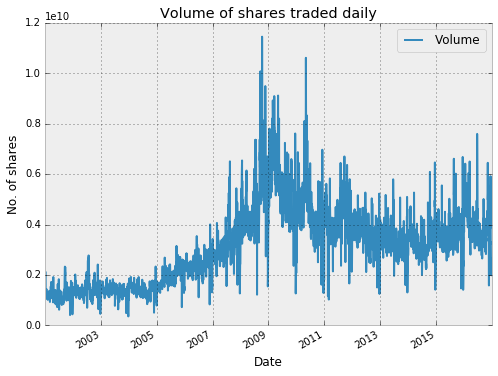

In [85]:
## volume graph
pp = volume_data.plot(figsize=(8,6))
pp.set_ylabel("No. of shares")
pp.set_title("Volume of shares traded daily")

#### This section corresponds to the data preprocessing section in the project report
Overview: 10 selected technical analysis indicators are created in this section

In [86]:
time_period = 15 ## no. of days to consider in a moving window algorithm

# Double Exponential Moving Average
tech_ind_DEMA = talib.DEMA(cumulative_price_points['Adj Close'].values, time_period)

# Directional Movement Index
tech_ind_DX = talib.DX(cumulative_price_points['High'].values, cumulative_price_points['Low'].values,cumulative_price_points['Close'].values, time_period)

# Average Directional Index
tech_ind_ADX = talib.ADX(cumulative_price_points['High'].values, cumulative_price_points['Low'].values,cumulative_price_points['Close'].values, time_period)

# Exponential Moving Average
tech_ind_EMA = talib.EMA(cumulative_price_points['Adj Close'].values, time_period)

# Momentum
tech_ind_MOM = talib.MOM(cumulative_price_points['Adj Close'].values, time_period)

# Rate of Change Percentage
tech_ind_ROCP = talib.ROCP(cumulative_price_points['Adj Close'].values, time_period)

# Relative Strength Index
tech_ind_RSI = talib.RSI(cumulative_price_points['Adj Close'].values, time_period)

# Simple Moving Average
tech_ind_SMA = talib.SMA(cumulative_price_points['Adj Close'].values, time_period)


# Williams %R
tech_ind_WILLR = talib.WILLR(cumulative_price_points['High'].values, cumulative_price_points['Low'].values,cumulative_price_points['Close'].values, time_period)

# Weighted Moving Average
tech_ind_WMA = talib.WMA(cumulative_price_points['Adj Close'].values, time_period)

In [87]:
## create new dataframe that contains technical analysis indicators 
tech_ind_dict = {'DEMA': tech_ind_DEMA,'DX': tech_ind_DX,'ADX': tech_ind_ADX,'EMA': tech_ind_EMA,
                 'MOM': tech_ind_MOM,'ROCP': tech_ind_ROCP,'RSI': tech_ind_RSI,'SMA': tech_ind_SMA,
                 'WMA': tech_ind_WMA,'WILLR': tech_ind_WILLR}
tech_ind = pd.DataFrame(tech_ind_dict)

Since all the values operate on a different scale, they will be normalized between [-1,1]

In [88]:
normalize_scaler = preprocessing.MaxAbsScaler()
tech_ind_not_null = tech_ind.iloc[2*time_period:, :]
tech_ind_scaled = tech_ind_not_null.apply(normalize_scaler.fit_transform)

Example Visualization of technical indicators

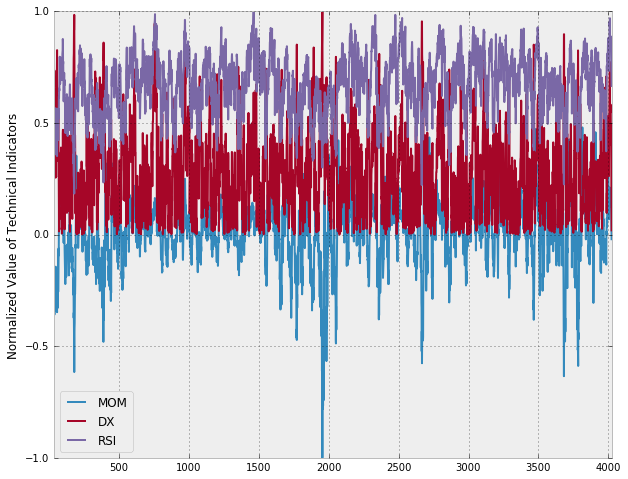

In [89]:
techa_data = tech_ind_scaled[['MOM', 'DX', 'RSI']]
pp = techa_data.plot(figsize=(10, 8))
pp.set_ylabel('Normalized Value of Technical Indicators')

#### This section corresponds to the implementation section of the project report
Overview: 
* Train-test split
* Linear Regression model creation
* Residual plot
* Calculate r2-score for checking fitness

In [90]:
pred_window = 1 # as in 1 day
train_ratio = 0.7 # for 70%

Y = cumulative_price_points['Adj Close'][2*time_period+pred_window:]
X = tech_ind_scaled.iloc[:len(Y), :]

train_data_length = int(len(Y)*train_ratio)
Y_train = Y[0:train_data_length]
Y_test = Y[train_data_length:]
X_train = X.iloc[:train_data_length, :]
X_test = X.iloc[train_data_length:, :]

X_constant = sm.add_constant(X_train)
clf = sm.OLS(Y_train.values, X_constant.values).fit()
MAE_LR_train = mean_absolute_error(Y_train.values, clf.predict(X_constant.values))
print MAE_LR_train

11.0166141238


In [91]:
predict_LR = clf.predict(sm.add_constant(X_test).values)
MAE_LR_test = mean_absolute_error(Y_test.values, predict_LR)
print 'The MAE of Linear Regression model on testing dataset is {}'.format(MAE_LR_test)

The MAE of Linear Regression model on testing dataset is 13.1067140565


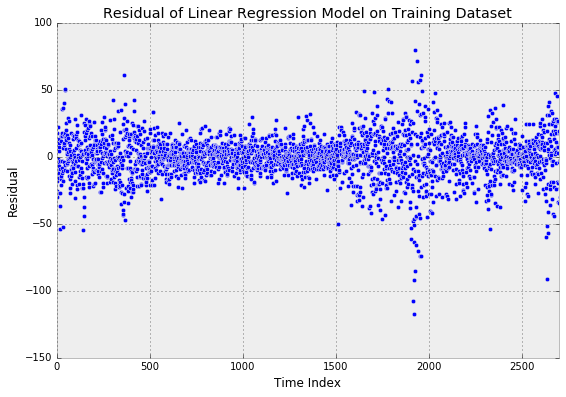

In [92]:
## create residual plot
plt.figure(figsize=(9,6))
plt.scatter(range(0, len(Y_train)), Y_train.values - clf.predict(X_constant.values))
plt.xlabel('Time Index')
plt.ylabel('Residual')
plt.xlim([0, 2700]) ## in order to fit the entire plot and not have empty spaces on the x-axis
plt.title('Residual of Linear Regression Model on Training Dataset')

In [93]:
## r2 score
R2 = r2_score(Y_train.values, clf.predict(X_constant.values))
print 'Coefficient of determination is', R2
print clf.summary()

Coefficient of determination is 0.992231401061
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 3.556e+04
Date:                Thu, 24 Aug 2017   Prob (F-statistic):               0.00
Time:                        22:20:44   Log-Likelihood:                -11640.
No. Observations:                2795   AIC:                         2.330e+04
Df Residuals:                    2784   BIC:                         2.337e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const

This model has a high r2 score, therefore it can successfully explain the underlying data

In [94]:
def performTimeSeriesCV(X_train, y_train, number_folds, model_function):
    """
    Given X_train and y_train (the test set is excluded from the Cross Validation),
    number of folds, the ML algorithm to implement and the parameters to test,
    the function acts based on the following logic: it splits X_train and y_train in a
    number of folds equal to number_folds. Then train on one fold and tests accuracy
    on the consecutive as follows:
    - Train on fold 1, test on 2
    - Train on fold 1-2, test on 3
    - Train on fold 1-2-3, test on 4
    """

    # k is the size of each fold. It is computed dividing the number of
    # rows in X_train by number_folds. This number is floored and coerced to int
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    #print 'Size of each fold: ', k

    # initialize to zero the accuracies array. It is important to stress that
    # in the CV of Time Series if I have n folds I test n-1 folds as the first
    # one is always needed to train
    accuracies = np.zeros(number_folds-1)
    train_accuracy = np.zeros(number_folds-1)
    # model_dict = {}
    # loop from the first 2 folds to the total number of folds
    for i in range(2, number_folds + 1):
        #print ''

        # the split is the percentage at which to split the folds into train
        # and test. For example when i = 2 we are taking the first 2 folds out
        # of the total available. In this specific case we have to split the
        # two of them in half (train on the first, test on the second),
        # so split = 1/2 = 0.5 = 50%. When i = 3 we are taking the first 3 folds
        # out of the total available, meaning that we have to split the three of them
        # in two at split = 2/3 = 0.66 = 66% (train on the first 2 and test on the
        # following)
        split = float(i-1)/i

        # example with i = 4 (first 4 folds):
        #      Splitting the first       4        chunks at          3      /        4
        #print 'Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i)

        # as we loop over the folds X and y are updated and increase in size.
        # This is the data that is going to be split and it increases in size
        # in the loop as we account for more folds. If k = 300, with i starting from 2
        # the result is the following in the loop
        # i = 2
        # X = X_train[:(600)]
        # y = y_train[:(600)]
        #
        # i = 3
        # X = X_train[:(900)]
        # y = y_train[:(900)]
        # ....
        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        #print 'Size of train + test: ', X.shape # the size of the dataframe is going to be k*i

        # X and y contain both the folds to train and the fold to test.
        # index is the integer telling us where to split, according to the
        # split percentage we have set above
        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        # i starts from 2 so the zeroth element in accuracies array is i-2.  y
        model_fit = model_function.fit(X_trainFolds, y_trainFolds)
        model_pred = model_fit.predict(X_testFold)
        accuracies[i-2] = mean_absolute_error(y_testFold, model_pred)
        train_accuracy[i-2] = mean_absolute_error(y_trainFolds, model_fit.predict(X_trainFolds))
        #print 'Mean Absolute Error on fold ' + str(i) + ': ', accuracies[i-2]

    # the function returns the mean of the accuracy on the n-1 folds
    return (accuracies.mean(), train_accuracy.mean())

In [97]:
c_param = [0.01, 0.1, 1.0, 10.0, 50.0, 100.0]  
fold_number = 5 # for how many folds to use
tmp = np.zeros(len(c_param))    # for MAE
test_set = []
train_set = []
for cost in range(len(c_param)):
    clf = svm.SVR(C=c_param[cost])
    test, train = performTimeSeriesCV(X_train, Y_train, fold_number, clf)
    test_set.append(test)
    train_set.append(train)
    
    
clf = svm.SVR(C=c_param[np.argmin(test_set)]).fit(X_train, Y_train)
train_pred_val = clf.predict(X_train)
MAE_SVM_train = mean_absolute_error(Y_train, train_pred_val)
test_pred_val = clf.predict(X_test)
MAE_SVM_test = mean_absolute_error(Y_test, test_pred_val)

print 'The MAE of SVM Regression model on testing dataset is {}'.format(MAE_SVM_test)

The MAE of SVM Regression model on testing dataset is 45.5410956743


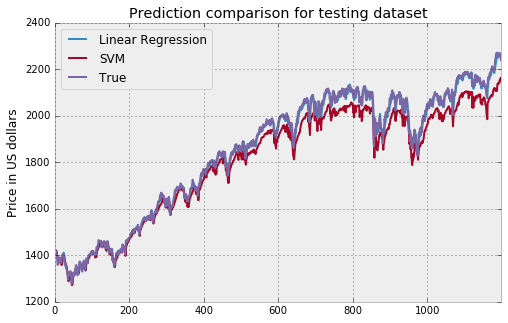

In [96]:
## final plot of results
# Combine all model results into a dataframe
prediction_test = pd.DataFrame({'True': Y_test.values,'Linear Regression': predict_LR,'SVM': test_pred_val})
# plot model predictions and true values
pp = prediction_test.plot(figsize=(8, 5), title='Prediction comparison for testing dataset')
pp.set_ylabel("Price in US dollars")